In [41]:
import os
import numpy as np
import pandas as pd
import collections
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from regression import *

In [3]:
file_path = (os.path.dirname(os.getcwd()) + '/data/')
data = pd.read_csv(file_path + '/Bank_Customer_Churn_Prediction.csv')

## DATA PREPROCESING ##

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [5]:
data.drop(columns="customer_id",axis=1,inplace=True)
data['country'] = data['country'].map({'France': 0, 'Spain' : 1,'Germany':2})
data['gender'] = data['gender'].map({'Male': 0, 'Female' : 1})
data['balance'] = data['balance'].astype('int64')
data['estimated_salary'] = data['estimated_salary'].astype('int64')
data.to_csv(file_path+'preprcessed_data.csv')
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   credit_score      10000 non-null  int64
 1   country           10000 non-null  int64
 2   gender            10000 non-null  int64
 3   age               10000 non-null  int64
 4   tenure            10000 non-null  int64
 5   balance           10000 non-null  int64
 6   products_number   10000 non-null  int64
 7   credit_card       10000 non-null  int64
 8   active_member     10000 non-null  int64
 9   estimated_salary  10000 non-null  int64
 10  churn             10000 non-null  int64
dtypes: int64(11)
memory usage: 859.5 KB


In [6]:
data.to_csv(file_path+'preprcessed_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   credit_score      10000 non-null  int64
 1   country           10000 non-null  int64
 2   gender            10000 non-null  int64
 3   age               10000 non-null  int64
 4   tenure            10000 non-null  int64
 5   balance           10000 non-null  int64
 6   products_number   10000 non-null  int64
 7   credit_card       10000 non-null  int64
 8   active_member     10000 non-null  int64
 9   estimated_salary  10000 non-null  int64
 10  churn             10000 non-null  int64
dtypes: int64(11)
memory usage: 859.5 KB


In [7]:
data.isnull().sum()

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [8]:
y = data['churn']
X = data.drop(columns='churn', axis = 1)

In [9]:
X.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,0,1,42,2,0,1,1,1,101348
1,608,1,1,41,1,83807,1,0,1,112542
2,502,0,1,42,8,159660,3,1,0,113931
3,699,0,1,39,1,0,2,0,0,93826
4,850,1,1,43,2,125510,1,1,1,79084


In [10]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(collections.Counter(y_resampled).items()))

[(0, 7963), (1, 7963)]


C:\Users\Teresa\AppData\Local\Temp\ipykernel_25312\2992105325.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn', data=dataframe,alpha=0.8,palette='pastel')


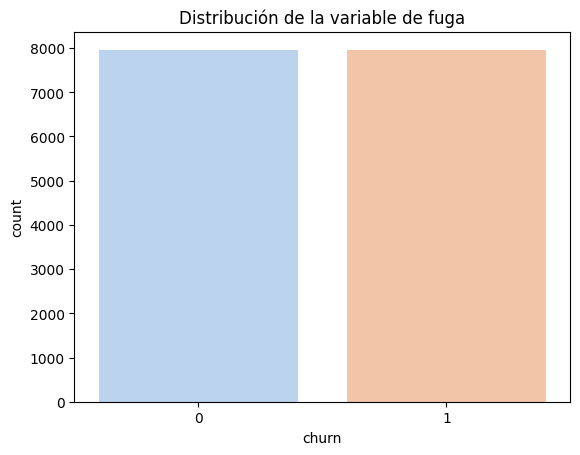

In [11]:
dataframe = pd.DataFrame(y_resampled)
sns.countplot(x='churn', data=dataframe,alpha=0.8,palette='pastel')
plt.title('Distribución de la variable de fuga')
plt.show()

In [12]:
X_resampled.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   credit_score      15926 non-null  int64
 1   country           15926 non-null  int64
 2   gender            15926 non-null  int64
 3   age               15926 non-null  int64
 4   tenure            15926 non-null  int64
 5   balance           15926 non-null  int64
 6   products_number   15926 non-null  int64
 7   credit_card       15926 non-null  int64
 8   active_member     15926 non-null  int64
 9   estimated_salary  15926 non-null  int64
dtypes: int64(10)
memory usage: 1.2 MB


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [14]:
sc= StandardScaler()
X_train_rescaled = sc.fit_transform(X_train)
X_test_rescaled = sc.transform(X_test)

In [15]:
print(X_train_rescaled.mean())
print(X_test_rescaled.mean())
print(X_train_rescaled.std())
print(X_test_rescaled.std())

4.305643579331219e-17
0.010756931593630038
1.0
1.0094989516610346


## LOGISTIC REGRESSION ##

### Fine-tuning ###

In [16]:
### Hyper-parameter tuning with Grid Search method.
param_grid = {'C' : range(5,20,5)}

clf_model = GridSearchCV(LogisticRegression(random_state=42),param_grid,cv=10, n_jobs=1, verbose=1)
clf_model = clf_model.fit(X_train_rescaled,y_train)

print ('Acuracy for LogisticRegression with BEST C:{} is {}'.format(
    clf_model.best_params_['C'],
    clf_model.best_score_))
    

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Acuracy for LogisticRegression with BEST C:5 is 0.7445054945054946


In [17]:
### Hyper-parameter tuning with Grid Search method.
"""param_grid = {'Cs' : range(5,20,5),
              'cv' : range(5,20,5)
            }

cv = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
clf_model = GridSearchCV(LogisticRegressionCV(random_state=42),param_grid,cv=cv, n_jobs=1, verbose=1)
clf_model = clf_model.fit(X_train_rescaled,y_train)

print ('Acuracy for LogisticRegressionCV with BEST Cs is:{0} and cv is{1}. The success rate is: {2}:'.format(
    clf_model.best_params_['Cs'], clf_model.best_params_['cv'],
    clf_model.best_score_))"""

"param_grid = {'Cs' : range(5,20,5),\n              'cv' : range(5,20,5)\n            }\n\ncv = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)\nclf_model = GridSearchCV(LogisticRegressionCV(random_state=42),param_grid,cv=cv, n_jobs=1, verbose=1)\nclf_model = clf_model.fit(X_train_rescaled,y_train)\n\nprint ('Acuracy for LogisticRegressionCV with BEST Cs is:{0} and cv is{1}. The success rate is: {2}:'.format(\n    clf_model.best_params_['Cs'], clf_model.best_params_['cv'],\n    clf_model.best_score_))"

In [18]:
from sklearn.model_selection import cross_validate
model_lr = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
scores = cross_validate(model_lr, X_train_rescaled, y_train,cv=cv, scoring=('accuracy', 'precision','recall','f1'),
                        return_train_score=True)

mean_accuracy = scores['test_accuracy'].mean()
mean_precision = scores['test_precision'].mean()
mean_recall = scores['test_recall'].mean()
mean_f1 = scores['test_f1'].mean()

print('Mean accuracy:', mean_accuracy)
print('Mean precision:', mean_precision)
print('Mean recall:', mean_recall)
print('Mean F1 score:', mean_f1)

Mean accuracy: 0.7445054945054945
Mean precision: 0.7359726722684339
Mean recall: 0.7677067082683308
Mean F1 score: 0.7514194442821915


### Train ###

In [19]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_rescaled,y_train)
y_pred = model_lr.predict(X_test_rescaled)

### Evaluation ###

In [20]:
accuracy = accuracy_score(y_test,y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7510985561833019
Precision: 0.7369077306733167
Recall: 0.7611075338055376
F1-score: 0.7488121634463097


### How many times was the classifier correct on the test set? ###

In [21]:
y_pred_train = model_lr.predict(X_train_rescaled)
# Find residual differences between train data and predicted train data
residuals = np.abs(y_train - y_pred_train)
# Print value counts of our predicted values 
print(pd.Series(residuals).value_counts())
print('----------------------------------')
# Print normalized value counts of our predicted values
print(pd.Series(residuals).value_counts(normalize = True))

churn
0    9491
1    3249
Name: count, dtype: int64
----------------------------------
churn
0    0.744976
1    0.255024
Name: proportion, dtype: float64


In [22]:
y_pred_test = model_lr.predict(X_test_rescaled)
# Find residual differences between train data and predicted train data
residuals = np.abs(y_test - y_pred_test)
# Print value counts of our predicted values 
print(pd.Series(residuals).value_counts())
print('----------------------------------')
# Print normalized value counts of our predicted values
print(pd.Series(residuals).value_counts(normalize = True))

churn
0    2393
1     793
Name: count, dtype: int64
----------------------------------
churn
0    0.751099
1    0.248901
Name: proportion, dtype: float64


In [32]:
# Call confusion_matrix function from sklearn.metrics using actual y_test and predicted y_test data sets 
cnf_matrix = confusion_matrix(y_test, y_pred_test, labels=model_lr.classes_)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1211  422]
 [ 371 1182]]


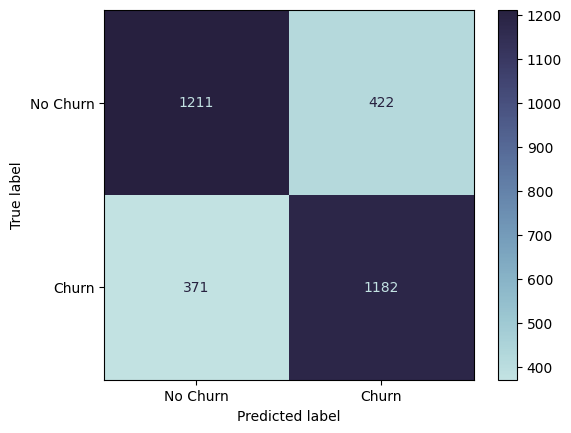

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

In [42]:
# Print 4 main logistic model metrics for training and test sets (Precision, Recall, Accuracy, F1)
print_metrics(y_train, y_pred_train, y_test, y_pred_test)

Training Metrics:
Training Precision:  0.74
Training Recall:  0.77
Training Accuracy:  0.74
Training F1-Score:  0.75


Testing Metrics:
Testing Precision:  0.74
Testing Recall:  0.76
Testing Accuracy:  0.75
Testing F1-Score:  0.75


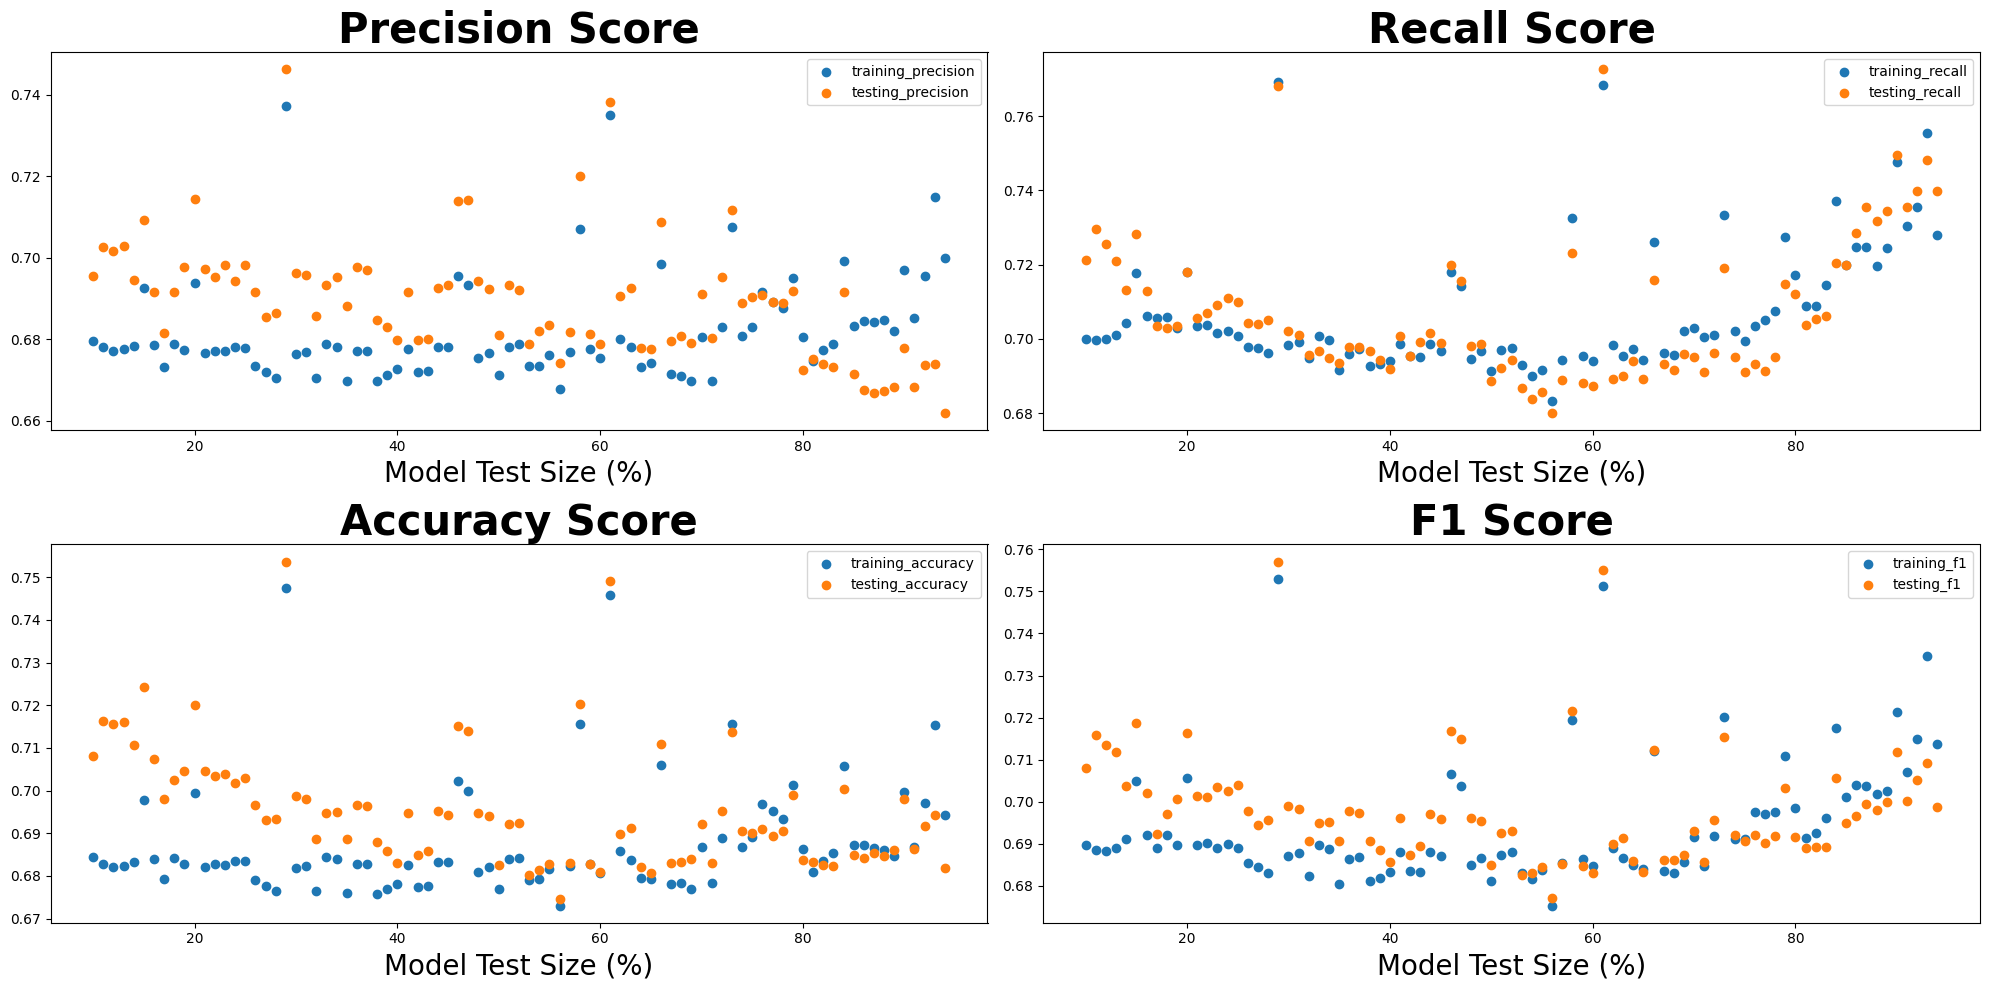

In [43]:
print_metric_comparisons(X_resampled, y_resampled)

c:\Users\Teresa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Teresa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Training AUC: 0.5805689914800384
Test AUC: 0.5875347834367554


FileNotFoundError: [Errno 2] No such file or directory: 'pics/Regression_pics/roc_curve.png'

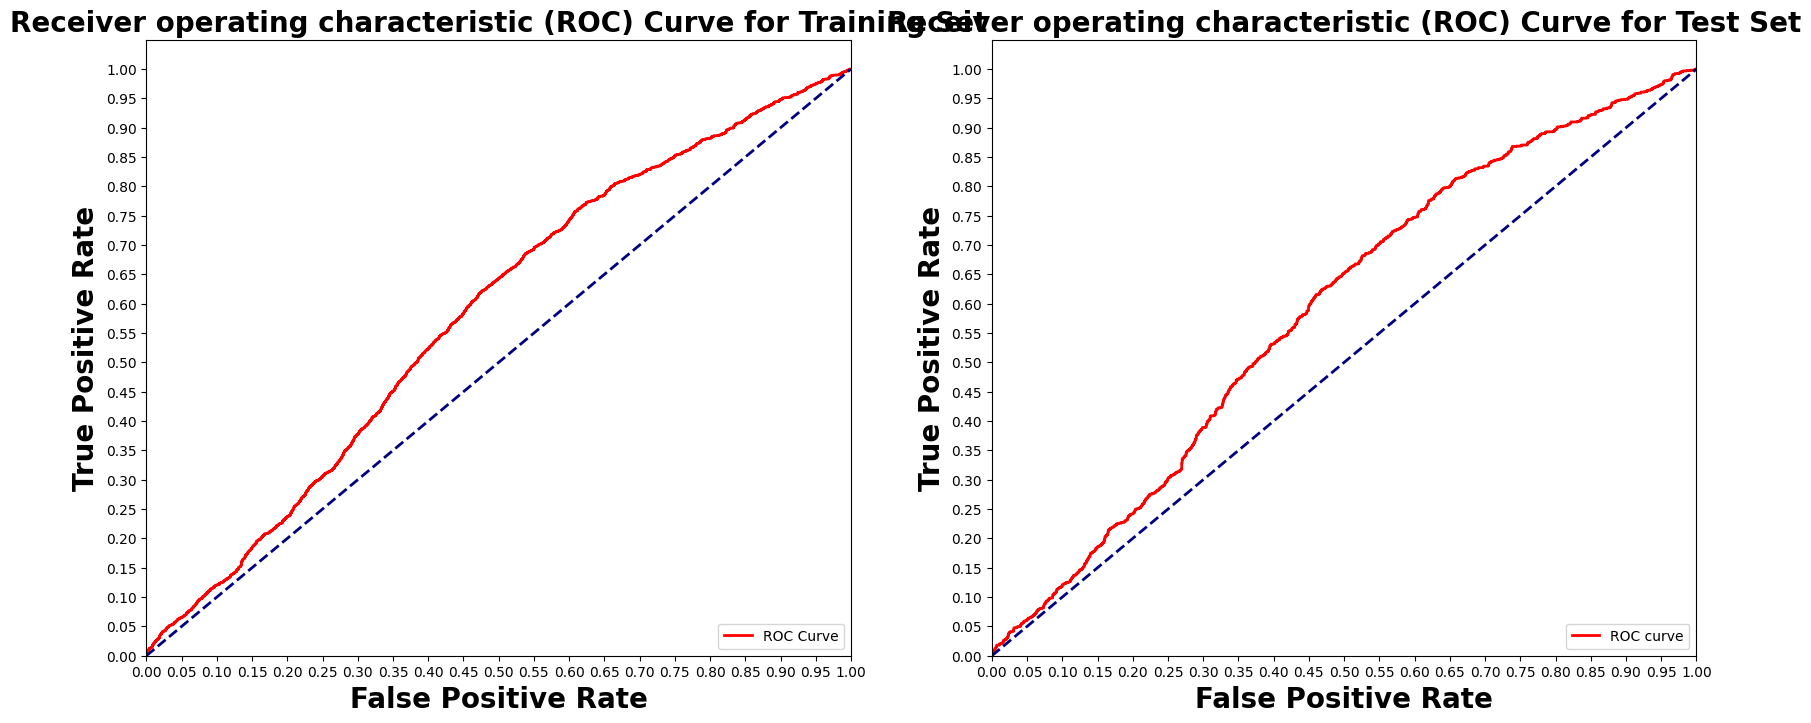

In [45]:
plot_auc(model_lr, X_train, X_test, y_train, y_test)

## XGB Classifier ##